# Day 4: Feature Engineering & Exploratory Data Analysis

## Objectives
- Create behavioural, temporal, and corridor-based features
- Explore differences between fraudulent and non-fraudulent transactions
- Identify features with strong predictive potential

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset produced on Day 3
DATA_PATH = "../data/processed/cleaned_transactions.csv"
df = pd.read_csv(DATA_PATH)

# Ensure timestamp is parsed correctly
df["timestamp"] = pd.to_datetime(df["timestamp"])

df.shape

(11040, 28)

In [4]:
# --- Temporal feature engineering ---

# Hour of transaction (0–23)
df["tx_hour"] = df["timestamp"].dt.hour

# Day of week (0 = Monday, 6 = Sunday)
df["tx_weekday"] = df["timestamp"].dt.weekday

# Weekend indicator
df["is_weekend"] = df["tx_weekday"].isin([5, 6]).astype(int)

df[["tx_hour", "tx_weekday", "is_weekend"]].head()

,tx_hour,tx_weekday,is_weekend
0,18,0,0
1,20,0,0
2,23,0,0
3,1,1,0
4,9,1,0


C:\Users\caspe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


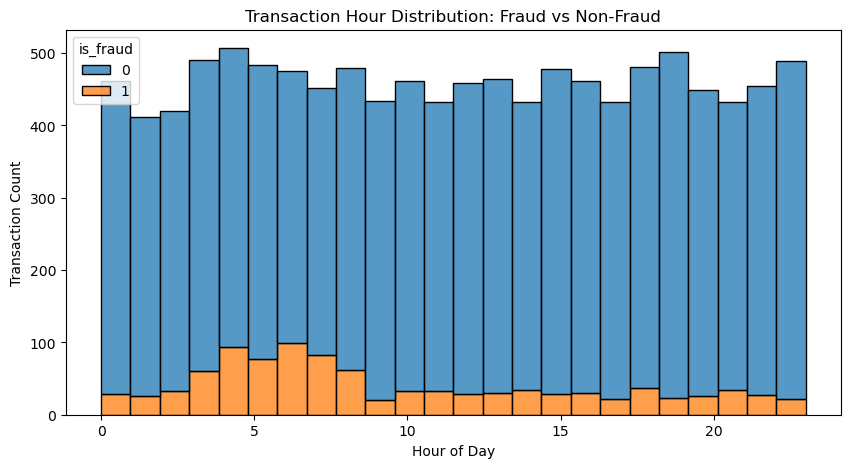

In [5]:
# Plot distribution of transaction hour by fraud label
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df,
    x="tx_hour",
    hue="is_fraud",
    bins=24,
    multiple="stack"
)
plt.title("Transaction Hour Distribution: Fraud vs Non-Fraud")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

Transaction frequency per customer

In [6]:
# --- Behavioural feature engineering ---

# Transactions per customer
tx_per_customer = (
    df.groupby("customer_id")["transaction_id"]
    .count()
    .rename("tx_count_customer")
)

# Merge back into main dataframe
df = df.merge(tx_per_customer, on="customer_id", how="left")

df[["customer_id", "tx_count_customer"]].head()

,customer_id,tx_count_customer
0,402cccc9-28de-45b3-9af7-cc5302aa1f93,1464
1,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,341
2,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,1031
3,7bd5200c-5d19-44f0-9afe-8b339a05366b,781
4,70a93d26-8e3a-4179-900c-a4a7a74d08e5,656


### Fraud rate by customer transaction volume

In [7]:
# Bin customers by transaction count
df["tx_count_bin"] = pd.qcut(
    df["tx_count_customer"],
    q=5,
    duplicates="drop"
)

fraud_rate_by_volume = (
    df.groupby("tx_count_bin")["is_fraud"]
    .mean()
)

fraud_rate_by_volume

C:\Users\caspe\AppData\Local\Temp\ipykernel_9736\3990763208.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("tx_count_bin")["is_fraud"]


tx_count_bin
(0.999, 136.0]      0.360158
(136.0, 781.0]      0.010726
(781.0, 1031.0]     0.007853
(1031.0, 1302.0]    0.043160
(1302.0, 1464.0]    0.008880
Name: is_fraud, dtype: float64

In [9]:
# --- Corridor feature engineering ---

# Combine source and destination currencies
df["corridor"] = (
    df["source_currency"] + "_to_" + df["dest_currency"]
)

df["corridor"].value_counts().head(10)

corridor
USD_to_NGN    1003
USD_to_PHP     922
USD_to_USD     910
USD_to_EUR     904
USD_to_GBP     897
USD_to_CNY     893
USD_to_INR     878
USD_to_CAD     877
USD_to_MXN     484
GBP_to_NGN     308
Name: count, dtype: int64

In [10]:
# Calculate fraud rate per corridor
corridor_fraud_rate = (
    df.groupby("corridor")["is_fraud"]
    .mean()
    .sort_values(ascending=False)
)

corridor_fraud_rate.head(10)

corridor
CAD_to_INR    0.607955
GBP_to_NGN    0.392857
USD_to_MXN    0.266529
GBP_to_EUR    0.150376
USD_to_NGN    0.133599
CAD_to_NGN    0.122951
USD_to_PHP    0.121475
GBP_to_CNY    0.100000
GBP_to_GBP    0.089744
GBP_to_USD    0.088608
Name: is_fraud, dtype: float64

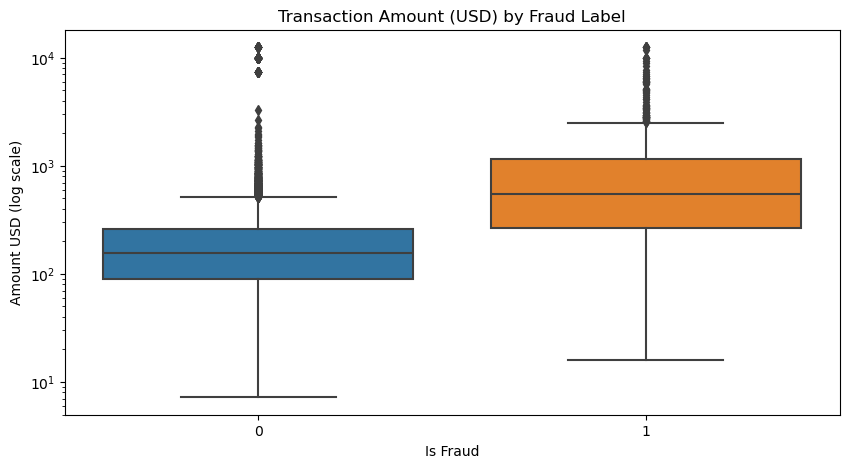

In [11]:
# Compare amount_usd distributions
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="is_fraud",
    y="amount_usd_num"
)
plt.yscale("log")
plt.title("Transaction Amount (USD) by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Amount USD (log scale)")
plt.show()

In [12]:
# Select numeric features for correlation
numeric_features = df.select_dtypes(include=["number"])

# Correlation with fraud label
fraud_corr = (
    numeric_features.corr()["is_fraud"]
    .sort_values(ascending=False)
)

fraud_corr.head(10)

is_fraud                     1.000000
txn_velocity_24h             0.755759
txn_velocity_1h              0.694019
risk_score_internal          0.606001
chargeback_history_count     0.582986
ip_risk_score                0.551614
corridor_risk                0.196307
exchange_rate_src_to_dest    0.153225
fee                          0.133570
amount_usd_num               0.132611
Name: is_fraud, dtype: float64

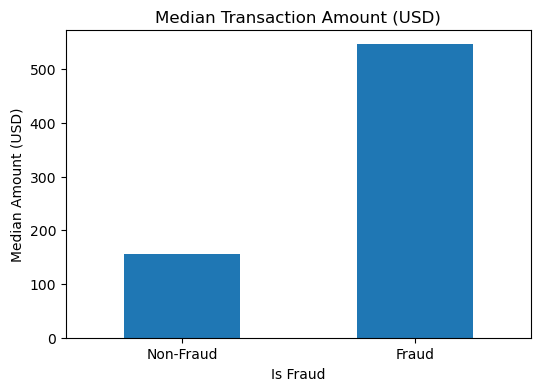

In [15]:
# --- Median transaction amount by fraud label ---

median_amounts = (
    df.groupby("is_fraud")["amount_usd_num"]
    .median()
)

median_amounts.plot(
    kind="bar",
    figsize=(6, 4),
    title="Median Transaction Amount (USD)"
)

plt.xticks([0, 1], ["Non-Fraud", "Fraud"], rotation=0)
plt.ylabel("Median Amount (USD)")
plt.xlabel("Is Fraud")
plt.show()

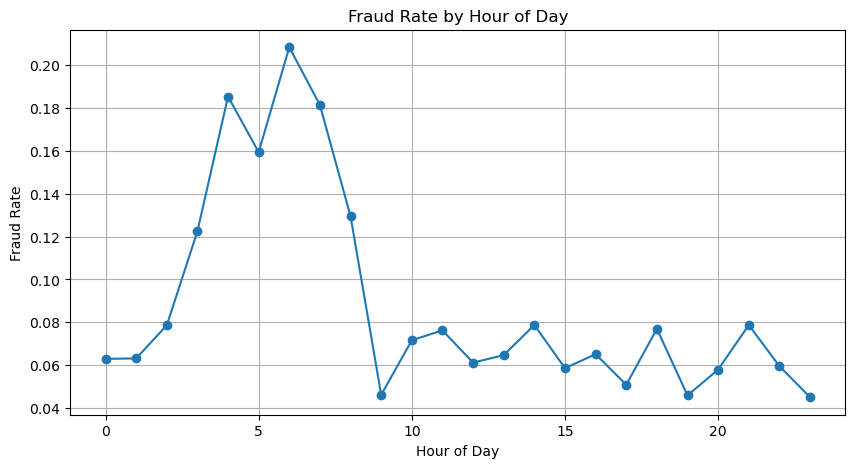

In [16]:
# --- Fraud rate by hour of day ---

fraud_rate_by_hour = (
    df.groupby("tx_hour")["is_fraud"]
    .mean()
)

plt.figure(figsize=(10, 5))
fraud_rate_by_hour.plot(marker="o")

plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()

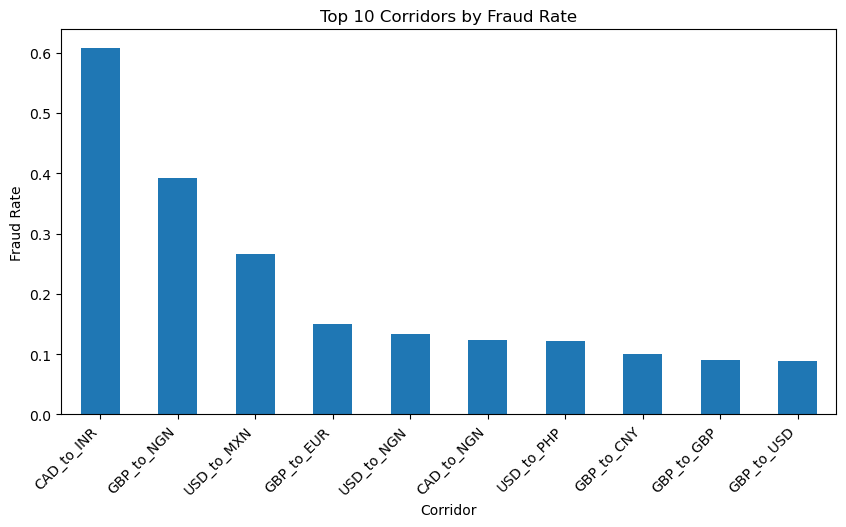

In [17]:
# --- Top 10 corridors by fraud rate ---

top_corridors = corridor_fraud_rate.head(10)

plt.figure(figsize=(10, 5))
top_corridors.plot(kind="bar")

plt.title("Top 10 Corridors by Fraud Rate")
plt.xlabel("Corridor")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha="right")
plt.show()

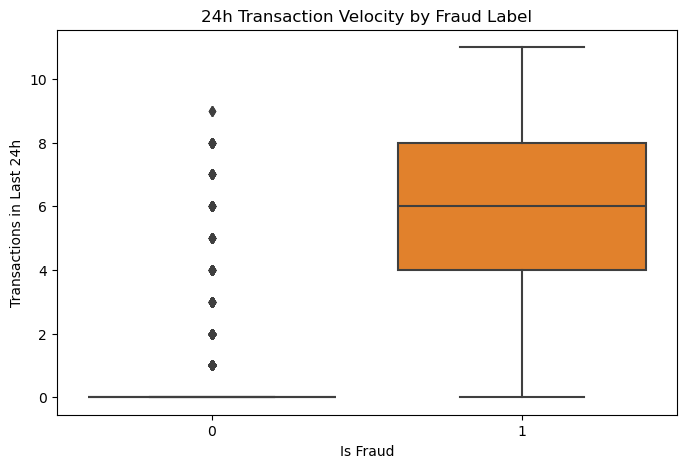

In [18]:
# --- Velocity feature vs fraud ---

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="is_fraud",
    y="txn_velocity_24h"
)

plt.title("24h Transaction Velocity by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Transactions in Last 24h")
plt.show()

In [19]:
# --- Recency feature engineering: preparation ---

# Sort transactions by customer and time
# This is critical for correct recency calculation
df = df.sort_values(
    by=["customer_id", "timestamp"]
).reset_index(drop=True)

In [20]:
# --- Recency feature engineering ---

# Calculate time difference between consecutive transactions per customer
df["time_since_prev_tx"] = (
    df.groupby("customer_id")["timestamp"]
    .diff()
)

# Convert time delta to hours
df["time_since_prev_tx_hours"] = (
    df["time_since_prev_tx"].dt.total_seconds() / 3600
)

In [21]:
# --- Handle missing recency values ---

# First transaction per customer has no previous transaction
# We fill these with a large value to indicate "long inactivity"
recency_median = df["time_since_prev_tx_hours"].median()

df["time_since_prev_tx_hours"] = (
    df["time_since_prev_tx_hours"]
    .fillna(recency_median)
)

recency_median

22.3875

In [22]:
# Quick check of recency feature
df["time_since_prev_tx_hours"].describe()

count    11040.000000
mean       128.353193
std        744.011175
min          0.000000
25%         10.119375
50%         22.387500
75%         46.771319
max      25107.165278
Name: time_since_prev_tx_hours, dtype: float64

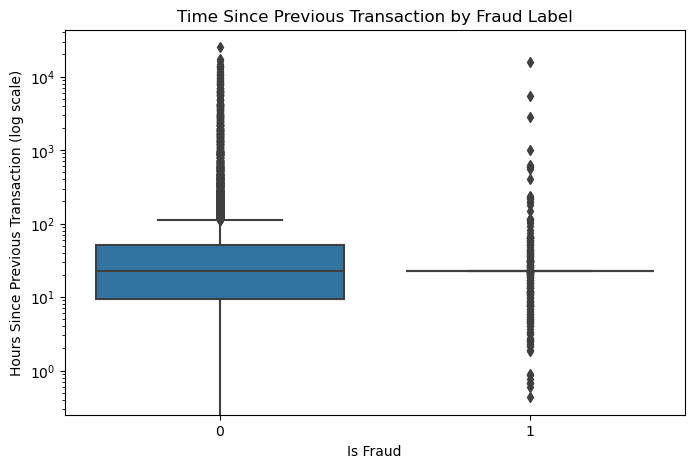

In [23]:
# --- Recency vs fraud label ---

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="is_fraud",
    y="time_since_prev_tx_hours"
)

plt.yscale("log")
plt.title("Time Since Previous Transaction by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Hours Since Previous Transaction (log scale)")
plt.show()

In [24]:
# --- Fraud rate by recency bucket ---

# Create recency bins (in hours)
df["recency_bin"] = pd.cut(
    df["time_since_prev_tx_hours"],
    bins=[0, 1, 6, 24, 72, 168, np.inf],
    labels=[
        "<1h",
        "1–6h",
        "6–24h",
        "1–3d",
        "3–7d",
        ">7d"
    ]
)

fraud_rate_by_recency = (
    df.groupby("recency_bin")["is_fraud"]
    .mean()
)

fraud_rate_by_recency

C:\Users\caspe\AppData\Local\Temp\ipykernel_9736\2605559287.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("recency_bin")["is_fraud"]


recency_bin
<1h      0.020528
1–6h     0.021785
6–24h    0.188597
1–3d     0.019851
3–7d     0.009740
>7d      0.017448
Name: is_fraud, dtype: float64

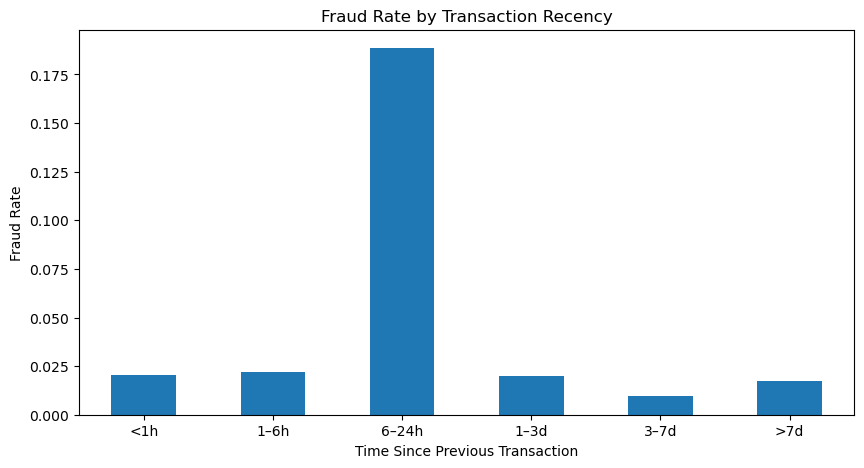

In [25]:
# --- Visualise fraud rate by recency bucket ---

plt.figure(figsize=(10, 5))
fraud_rate_by_recency.plot(kind="bar")

plt.title("Fraud Rate by Transaction Recency")
plt.xlabel("Time Since Previous Transaction")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=0)
plt.show()